# TP SVM classification: active learning


Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

In [58]:
#necessary imports
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score

## MNIST dataset

In [59]:
# loading the dataset
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()


**Question 1** 
- What is the dimension of the data space ? 
- How many data in the train dataset ?

Compute these values (even if they are available on the net). Print the results in the form (10 and 100 are examples, not the correct values):

    Data are of dimension: 10.
    There are 100 data in the train dataset.

In [60]:
#your answer

print('Data are of dimension: ',x_train.ndim)

Data are of dimension:  3


In [61]:
print('Data in the train dataset',y_train.data.shape)

Data in the train dataset (60000,)


**Question 1b**: If needed, reshape the data

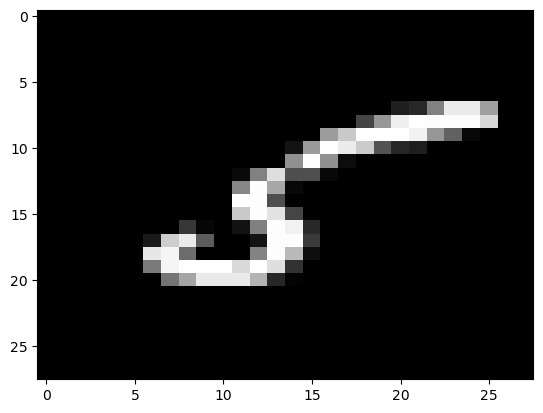

5


In [62]:
#your answer, if needed

import matplotlib.pyplot as plt
i = 11
plt.imshow(x_train[i],aspect="auto",cmap='gray')
plt.show()
print(y_train[i])

In [63]:
# reshaping the data (a 2d image is transformed to a 1d array)
#train
n = x_train.shape[0]
x_trainLin = x_train.reshape(n,-1)
#test
n = x_test.shape[0]
x_testLin = x_test.reshape(n,-1)



In [64]:
# you will now consider only 2 classes: the 3's and the 7's
c1 = 3
c2 = 7

namec1 = '3'
namec2 = '7'
mesClassesTrain = (y_train==c1)|(y_train==c2)
mesClassesTest = (y_test==c1)|(y_test==c2)


# case of binary classification: we choose '4' and '8' or coats and bags

# you can change the classes
#class1 = 4 #negative class 'coats'
#class2 = 8 #positive class 'bags'
#nameClass1 = '4'
#nameClass2 = '8'
#mesClassesTrain = (y_train==class1)|(y_train==class2)
#mesClassesTest = (y_test==class1)|(y_test==class2)

**Question 2:**

Set Xtrain and Xtest to contain the part of the data from the original dataset that contains only data with labels 3 or 7. Set yTrain and yTest to the corresponding labels: 0 value for class '3' and 1 value for class '7'.

In [65]:
#your answer

## TRAIN
x_trainBinaire = np.array(x_trainLin[mesClassesTrain,:])
y_trainBinaire = np.array((y_train[mesClassesTrain]-c1)/(c2-c1))

## TEST
x_testBinaire = np.array(x_testLin[mesClassesTest,:])
y_testBinaire = np.array((y_test[mesClassesTest]-c1)/(c2-c1))

In [66]:
x_trainBinaire.data.shape

(12396, 784)

In [67]:
x_testBinaire.shape

(2038, 784)

**Question 3:**

How many samples for class '3' and for class '7'? Print the values this way:
    
    Train: There are ... data in class 3 and ... data in class 7.
    Test: There are ... data in class 3 and ... data in class 7.

In [68]:
#your answer
mesClassesTrain3 = (y_train==c1)
mesClassesTest3 = (y_test==c1)
mesClassesTrain7=(y_train==c2)
mesClassesTest7= (y_test==c2)
x_trainBinaire3 = np.array(x_trainLin[mesClassesTrain3,:])
x_testBinaire3 = np.array(x_testLin[mesClassesTest3,:])
x_trainBinaire7 = np.array(x_trainLin[mesClassesTrain7,:])
x_testBinaire7 = np.array(x_testLin[mesClassesTest7,:])


In [69]:
x_trainBinaire3.shape

(6131, 784)

In [70]:
x_trainBinaire7.shape

(6265, 784)

In [71]:
print('Train: There are 6131 data in class 3 and 6265 data in class 7.')

Train: There are 6131 data in class 3 and 6265 data in class 7.


In [72]:
x_testBinaire3.shape

(1010, 784)

In [73]:
x_testBinaire7.shape

(1028, 784)

In [74]:
print('Test: There are 1010 data in class 3 and 1028 data in class 7.')

Test: There are 1010 data in class 3 and 1028 data in class 7.


## Baseline: train a linear SVM on the whole train dataset

**Question 4:**

Using a linear kernel and a default C value to 1, learn the SVM classification of 3's versus 7's with the whole train dataset.


In [75]:
#your answer

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score

model = svm.SVC(kernel='linear', C=1)

model.fit(x_trainBinaire, y_trainBinaire)


SVC(C=1, kernel='linear')

**Question 5:**

Compute the different metrics (F1 score, accuracy and confusion matrix) on the test dataset.

C:\Users\SamiYa bou\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


F1 score :  0.976401179941003


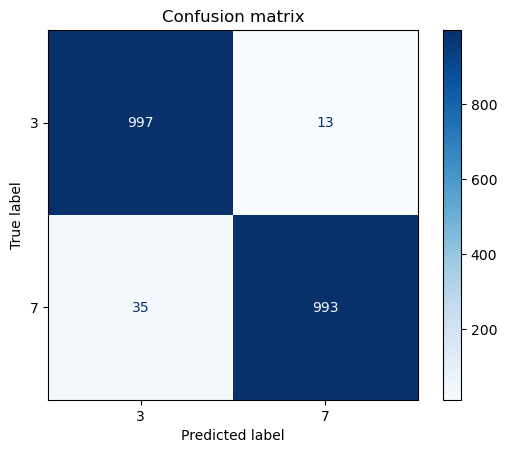

In [76]:
#your answer
y_predBinaireTest =model.predict(x_testBinaire)  ## compute the prediction of x_testBinaireLin using your learned classifier

disp = plot_confusion_matrix(model , x_testBinaire, y_testBinaire,
                                 display_labels=[nameClass1,nameClass2],
                                 cmap=plt.cm.Blues,
                                 normalize=None)
disp.ax_.set_title('Confusion matrix')
print("F1 score : ", f1_score(y_predBinaireTest,y_testBinaire))

## Active learning with SVM

Start with few annoted data and iterate by asking new labelled data and re-learn SVM separation. Try different selection of new labelled data.

In [78]:
Xtrain = np.array(x_trainLin[mesClassesTrain,:])
yTrain = np.array((y_train[mesClassesTrain]-c1)/(c2-c1))

In [79]:
# short reminder for random integers:
import random
a = random.randint(2, 15)
# a is random integer such that 2 <= a <= 15

In [80]:
#In order to avoid any modification in (xTrain, yTrain), we will work on a copy in the next cells:
xTrainP = np.copy(Xtrain)
yTrainP = np.copy(yTrain)

**Question 6: Initialisation of the active training dataset**

Construct a new training dataset named (xActif,yActif). For it's initialisation, take randomly nb0 data from the copy of the original training dataset (xTrainP, yTrainP). You are allowed to use informations from yTrainP in order to get half of nb0 data for each class. These nb0 data are also removed from (xTrainP,yTrainP). Removing data can be done using [np.delete](https://numpy.org/doc/stable/reference/generated/numpy.delete.html).

In [81]:
# we assume that nb0 is an even number
nb0 = 4 # number of data in the active training dataset at initialisation
xActif = []
yActif = []

In [82]:
#your answer
for n in range(int(nb0/2)):
    i=random.randint(0, len(yTrainP)-1)
    while yTrainP[i]==0:
        i = random.randint(0, len(yTrainP)-1)
    xActif.append(xTrainP[i])
    yActif.append(xTrainP[i])
    xTrainP=np.delete(xTrainP, i, axis=0)
    yTrainP=np.delete(yTrainP, i)
for n in range (int(nb0/2)):
    i = random.randint(0, len(yTrainP)-1)
    while yTrainP[i]==1:
        i= random.randint(0, len(yTrainP)-1) 
    xActif.append(xTrainP[i])
    yActif.append(xTrainP[i])
    xTrainP=np.delete(xTrainP, i, axis=0)
    yTrainP=np.delete(yTrainP, i)

**Question 7: Iterations of the active learning** 

1. Learn a linear SVM classifier on the active training dataset
2. Compute the accuracy on the test dataset (not modified)
3. add randomly nb new data to the active training dataset and remove them from (xTrainP, yTrainP)
4. Go back to step 1 (20 times)

In [ ]:
#your answer   

**Question 8: plot the evolution of the accuracy**

Plot the accuracy with respect to the iterations from the previous question.

**Question 9: strategy for choosing new data**
    
Same question as question 7 but, instead of choosing the new points randomly, at each iteration, choose the nb points that are the closest to the separation. The [decision_function](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC.decision_function) from scikit-learn will help you.

In [ ]:
#your answer

**Question 10: plot the evolution of the accuracy**

Plot the accuracy with respect to the iterations from the previous question.
Compare with question 8. Also compare with the baseline.

In [ ]:
#your answer

**Question 11: many random starts**
    
Since the initialisation is random, running previous codes can lead to different curves for questions 8 and 10. Write here the code necessary for plotting several (e.g. 10) curves corresponding to questions 8 and 10 and display these new plots. Which one is the best strategy?
    

In [ ]:
#your answer

**Question 12: hyperparameters**
So far, you have used the linear kernel with default parameter. Using the strategy of question 9, how could you choose the kernel and the hyperparameters ? Try different experiments such as:
- choose the kernel and hyperparams using nb0 at starting
- update kernel and hyperparams after few itertions
- compare different trials    
    